### 1. BUSINESS PROBLEM

In this digital era, e-commerce platforms face the challenge of accurately analyzing vast amounts of customer feedback to assess product sentiment. Understanding this sentiment is crucial for businesses to make informed decisions about product improvements, marketing strategies, and customer satisfaction. However, manually sifting through thousands of reviews is both time-consuming and inefficient. To address this, the company plans to develop a robust automated sentiment analysis system, designed to efficiently process and interpret reviews from Amazon, with a specific focus on the Electronics category.

### 2. PROJECT OBJECTIVE

By leveraging Data Science techniques, this project aims to develop an end-to-end model that can extract, preprocess, analyze, and visualize customer sentiment from textual reviews. The challenge lies in efficiently processing large volumes of text data and accurately capturing the subtle emotions expressed. A successful implementation of sentiment analysis and modeling will significantly enhance customer trust and loyalty, which will in turn, drive business growth.

### 3. IMPORT LIBRARIES

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from flask import Flask, request, jsonify
import streamlit as st
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bashy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bashy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bashy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bashy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 4. LOAD DATASET

In [2]:
data = pd.read_csv('text_review.csv')

# Make a copy of the dataset
data1 = data.copy()

### 5. DATA OVERVIEW

In [3]:
# Check the first 5 rows
data.head()

,Reviewer,Country,StarRatings,Subject,Review,Date_posted
0,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...","Tuesday, June 4, 2024"
1,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,"Tuesday, June 4, 2024"
2,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...","Monday, June 3, 2024"
3,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,"Sunday, June 2, 2024"
4,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,"Tuesday, June 4, 2024"


In [4]:
# Check the dimensionality of the data
data.shape

(12000, 6)

In [5]:
# View summary of the dataset and check for anomalies
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Reviewer     11997 non-null  object
 1   Country      11997 non-null  object
 2   StarRatings  12000 non-null  int64 
 3   Subject      12000 non-null  object
 4   Review       11161 non-null  object
 5   Date_posted  12000 non-null  object
dtypes: int64(1), object(5)
memory usage: 562.6+ KB


In [6]:
# Inspect data types
data.dtypes

Reviewer       object
Country        object
StarRatings     int64
Subject        object
Review         object
Date_posted    object
dtype: object

In [7]:
# Check statistical description of numerical feature
data.describe()

,StarRatings
count,12000.000000
mean,2.677500
std,1.897224
min,1.000000
25%,1.000000
50%,1.000000
75%,5.000000
max,5.000000


In [8]:
# Check statistical description of categorical feature
data.describe(include = 'object')

,Reviewer,Country,Subject,Review,Date_posted
count,11997,11997,12000,11161,12000
unique,11065,147,11177,11158,1372
top,customer,GB,I'm very satisfied,I'm very satisfied,"Monday, September 28, 2020"
freq,52,2733,22,2,39


In [9]:
# Count values of the features in the dataset
data.count()

Reviewer       11997
Country        11997
StarRatings    12000
Subject        12000
Review         11161
Date_posted    12000
dtype: int64

In [10]:
# Check the unique values in each feature
data.nunique()

Reviewer       11065
Country          147
StarRatings        5
Subject        11177
Review         11158
Date_posted     1372
dtype: int64

In [11]:
# Check for duplicates
data.duplicated().sum()

np.int64(0)

No duplicates in the dataset

In [12]:
# Check for missing values
data.isnull().sum()

Reviewer         3
Country          3
StarRatings      0
Subject          0
Review         839
Date_posted      0
dtype: int64

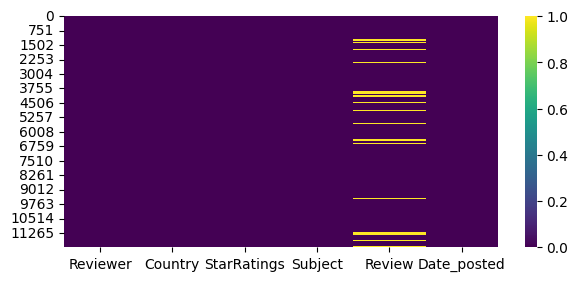

In [13]:
# Visualize missing values
plt.figure(figsize=(7,3))
sns.heatmap(data.isnull(),cbar=True, cmap="viridis");

There are: 
- 3 missing values in the Reviewer column
- 3 missing values in the Country column
- 839 missing values in the Reviews column

In [14]:
# Check the column features
print(f"Feature Names: {data.columns.values}")

Feature Names: ['Reviewer' 'Country' 'StarRatings' 'Subject' 'Review' 'Date_posted']


In [15]:
# Convert the date_posted from object to pandas datetime function 
data["Date_posted"] = pd.to_datetime(data["Date_posted"])
data.head()

,Reviewer,Country,StarRatings,Subject,Review,Date_posted
0,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","Amazon is easy to work with, but they fulfill ...",2024-06-04
1,Arthur Riding,GB,5,"Great range of products, generally superior qu...",I have been using AliExpress for well over a y...,2024-06-04
2,UK shopper Val,GB,5,Good!,"A good, customer-centric marketplace. But neve...",2024-06-03
3,Jim Corkery,CA,1,I purchased an Android Tesla style…,I purchased an Android Tesla style radio.\nAft...,2024-06-02
4,chris bardin,IE,1,They are an absolute con job dont waste…,They are an absolute con job dont waste your m...,2024-06-04


### 6. EXPLORATIVE DATA ANALYSIS

In [16]:
# Check Customers' reviews texts in the Review column
data['Country'].value_counts()

Country
GB    2733
US    1967
CA     770
AU     582
NL     386
      ... 
MG       1
SZ       1
UY       1
HM       1
KG       1
Name: count, Length: 147, dtype: int64

In [17]:
# StarRatings Value Count
data['StarRatings'].value_counts()

StarRatings
1    6418
5    4488
2     412
4     402
3     280
Name: count, dtype: int64

Top 10 countries with high StarRatings (3-5 StarRatings):
    Country  HighRatingsCount
123      US               624
41       GB               532
21       CA               272
6        AU               243
17       BR               228
89       NL               220
38       ES               192
40       FR               187
55       IL               169
92       NZ               152


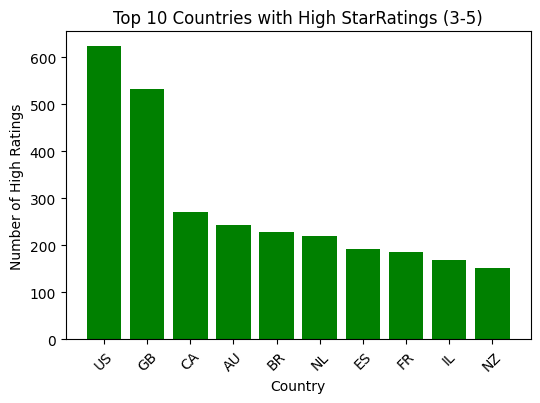

In [18]:
# Top 10 Countries with high StarRatings (3-5)

# Filter reviews with high StarRatings (3-5)
high_ratings = data[data['StarRatings'].between(3, 5)]

# Group by 'Country' and count the number of high ratings for each country
high_ratings_count = high_ratings.groupby('Country').size().reset_index(name='HighRatingsCount')

# Sort the results and get the top 10 countries with high ratings
top_10_high_ratings = high_ratings_count.sort_values(by='HighRatingsCount', ascending=False).head(10)

# Display the results
print("Top 10 countries with high StarRatings (3-5 StarRatings):")
print(top_10_high_ratings)

# Plot the top 10 countries with high StarRatings (3-5)
plt.figure(figsize=(6, 4))
plt.bar(top_10_high_ratings['Country'], top_10_high_ratings['HighRatingsCount'], color='green')
plt.xlabel('Country')
plt.ylabel('Number of High Ratings')
plt.title('Top 10 Countries with High StarRatings (3-5)')
plt.xticks(rotation=45)
plt.show()


Top 10 countries with low StarRatings (1-2 StarRatings):
    Country  LowRatingsCount
38       GB             2201
112      US             1343
17       CA              498
7        AU              339
50       IE              181
84       NL              166
28       DK              139
87       NZ              138
27       DE              133
34       ES              128


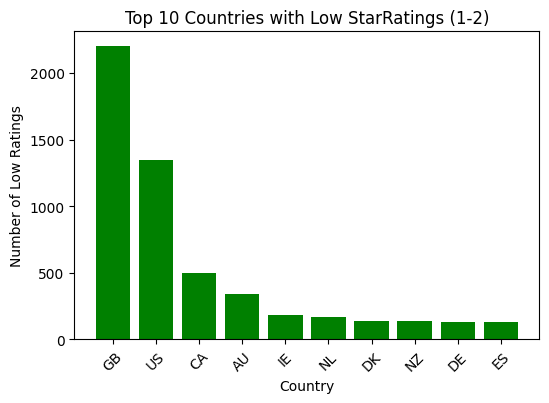

In [19]:
# Top 10 Countries with low StarRatings (1-2)

# Filter reviews with low StarRatings (1-2)
low_ratings = data[data['StarRatings'].between(1, 2)]

# Group by 'Country' and count the number of low ratings for each country
low_ratings_count = low_ratings.groupby('Country').size().reset_index(name='LowRatingsCount')

# Sort the results and get the top 10 countries with low ratings
top_10_low_ratings = low_ratings_count.sort_values(by='LowRatingsCount', ascending=False).head(10)

print("\nTop 10 countries with low StarRatings (1-2 StarRatings):")
print(top_10_low_ratings)

# Plot the top 10 countries with low StarRatings (1-2)
plt.figure(figsize=(6, 4))
plt.bar(top_10_low_ratings['Country'], top_10_low_ratings['LowRatingsCount'], color='green')
plt.xlabel('Country')
plt.ylabel('Number of Low Ratings')
plt.title('Top 10 Countries with Low StarRatings (1-2)')
plt.xticks(rotation=45)
plt.show()

StarRatings
1    6418
2     412
3     280
4     402
5    4488
Name: count, dtype: int64


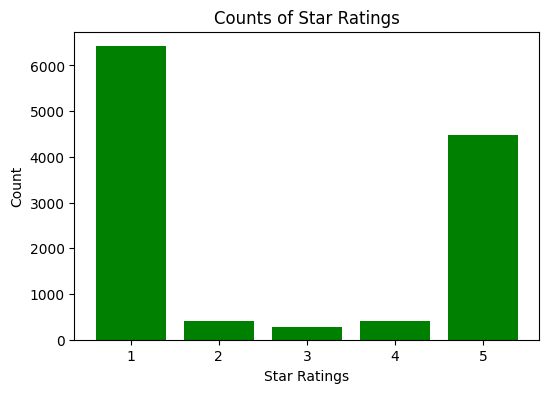

In [20]:
# Check Customers' StarRatings
star_ratings_count = data['StarRatings'].value_counts().sort_index()

print(star_ratings_count)

# Plot the StarRatings counts
plt.figure(figsize=(6, 4))
plt.bar(star_ratings_count.index.astype(str), star_ratings_count.values, color='green')
plt.xlabel('Star Ratings')
plt.ylabel('Count')
plt.title('Counts of Star Ratings')
plt.show()

StarRatings
1    53.48
5    37.40
2     3.43
4     3.35
3     2.33
Name: count, dtype: float64


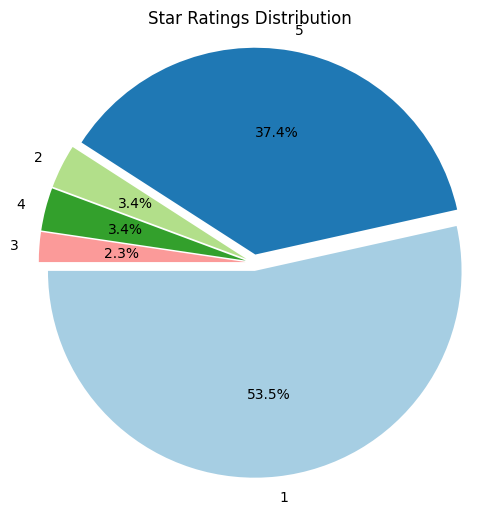

In [21]:
# Percentage Distribution of StarRatings
star_ratings = round(data['StarRatings'].value_counts()/data.shape[0]*100,2)
print(star_ratings)

# Plot pie chart for the star ratings distribution
explode = [0.04] * len(star_ratings)
plt.figure(figsize=(6, 6))
plt.pie(star_ratings, labels=star_ratings.index, autopct='%1.1f%%', startangle=180, colors=plt.cm.Paired.colors, 
        explode=explode)
plt.title('Star Ratings Distribution')
plt.axis('equal')
plt.show()

In [22]:
# Check Customers' reviews texts in the Review column
data[['StarRatings', 'Review']].values[:5]

array([[3,
        "Amazon is easy to work with, but they fulfill their orders via 3rd party companies and working with them is hit or miss. I ordered a Bread Proofer and received a Snow Cone Maker! I've spent over an hour chatting with them trying to resolve it and Amazon sent me to Cherry Surprise Store, who acknowledged my return request, but said they would forward it to Amazon! I'm not 100% sure what will happen next."],
       [5,
        "I have been using AliExpress for well over a year now and have been consistently impressed with their range and quality of their products, as well as of course their prices, in the vast majority of cases far, far, better on all fronts above than their big competitors in the UK. I also particularly like the number of places on their site where you can arrange for your own pictures/designs to be printed on shirts, bags, cases, flags, etc etc etc.\nBrilliant.\nSure, you have to wait longer to receive one's order from AliExpress, in practise 2 to 3

### 7. DATA PREPROCESSING

In [23]:
# Convert the comments in the review column to lowercase.
# To standardizes the data into a uniform format, eliminating inconsistencies that might arise from differences in case 
#  sensitivity during the text processing phase.

data['Review'] = data['Review'].str.lower()

In [24]:
# Remove special characters, numbers and space
data['Review'] = data['Review'].astype(str)
data['Review'] = data['Review'].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

In [25]:
# Remove frequetly repeated words (Stopwords)
stop_words = set(stopwords.words('english'))
data['Review'] = data['Review'].apply(lambda x:" ".join(x for x in str(x).split() if x not in stop_words))

In [26]:
# Obtain root forms of words in Review column using Lemmetization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['Review'] = data['Review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [27]:
# Tokenization (Transform text in Review into a structured format)
from nltk.tokenize import word_tokenize 
data['Review'] = data['Review'].apply(lambda x: word_tokenize(x))

In [28]:
data['Review'][:5]

0    [amazon, easy, work, fulfill, order, via, rd, ...
1    [using, aliexpress, well, year, consistently, ...
2    [good, customercentric, marketplace, neverthel...
3    [purchased, android, tesla, style, radio, inst...
4    [absolute, con, job, dont, waste, money, scamm...
Name: Review, dtype: object

In [29]:
# Write a function for the Data Preprocessing
def clean_text(text):
    text = str(text)
    text = text.lower() # to convert words to lowercase
    text = re.sub(r"[^a-zA-Z\s]", "", text) # remove special characters and numbers
    text = re.sub(r"\st", " ", text).strip() # remove extra spaces
    tokens = word_tokenize(text) # tokenize text
    tokens = [word for word in tokens if word not in stop_words] # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # lemmatize tokens
    return " ".join(tokens)

data['clean_review'] = data['Review'].apply(clean_text)

In [30]:
data['clean_review'][:5]

0    amazon easy work fulfill order via rd party co...
1    using aliexpress well year consistently impres...
2    good customercentric marketplace nevertheless ...
3    purchased android esla style radio installed s...
4    absolute con job dont waste money scammer rece...
Name: clean_review, dtype: object

### 8. SENTIMENT ANALYSIS (with VADER Sentiment Analysis and TextBlob Sentiment Analysis Models)

In [31]:
# Download necessary NLTK data
nltk.download('vader_lexicon')
from tqdm.notebook import tqdm
from textblob import TextBlob

# Instantiate VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bashy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [32]:
sia.polarity_scores('I am so happy')

{'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}

In [33]:
sia.polarity_scores('i dont like it')

{'neg': 0.513, 'neu': 0.487, 'pos': 0.0, 'compound': -0.2755}

In [34]:
# Run polarity score on Review with high StarRatings
sia.polarity_scores(data['clean_review'][1])

{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'compound': 0.9689}

In [35]:
# Run polarity score on Review with low StarRatings
sia.polarity_scores(data['clean_review'][4])

{'neg': 0.073, 'neu': 0.792, 'pos': 0.135, 'compound': 0.2575}

In [36]:
data['ID'] = data.index.map(lambda x: f'{x:02}')
data = data[['ID'] + [col for col in data.columns if col != 'ID']]
data.head()

,ID,Reviewer,Country,StarRatings,Subject,Review,Date_posted,clean_review
0,00,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","[amazon, easy, work, fulfill, order, via, rd, ...",2024-06-04,amazon easy work fulfill order via rd party co...
1,01,Arthur Riding,GB,5,"Great range of products, generally superior qu...","[using, aliexpress, well, year, consistently, ...",2024-06-04,using aliexpress well year consistently impres...
2,02,UK shopper Val,GB,5,Good!,"[good, customercentric, marketplace, neverthel...",2024-06-03,good customercentric marketplace nevertheless ...
3,03,Jim Corkery,CA,1,I purchased an Android Tesla style…,"[purchased, android, tesla, style, radio, inst...",2024-06-02,purchased android esla style radio installed s...
4,04,chris bardin,IE,1,They are an absolute con job dont waste…,"[absolute, con, job, dont, waste, money, scamm...",2024-06-04,absolute con job dont waste money scammer rece...


In [37]:
# Run polarity score on the entire dataset
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['clean_review']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/12000 [00:00<?, ?it/s]

In [38]:
#res

In [39]:
# VADER Sentiment polarity score
vader_score = pd.DataFrame(res).T
vader_score.head()

,neg,neu,pos,compound
00,0.030,0.583,0.387,0.9432
01,0.000,0.694,0.306,0.9689
02,0.153,0.587,0.259,0.6705
03,0.000,0.909,0.091,0.5719
04,0.073,0.792,0.135,0.2575


In [40]:
# Merge VADER sentiment polarity score with original dataframe
vader_score = vader_score.reset_index().rename(columns={'index': 'ID'})
data = data.merge(vader_score, how='left')
data.head()

,ID,Reviewer,Country,StarRatings,Subject,Review,Date_posted,clean_review,neg,neu,pos,compound
0,00,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","[amazon, easy, work, fulfill, order, via, rd, ...",2024-06-04,amazon easy work fulfill order via rd party co...,0.030,0.583,0.387,0.9432
1,01,Arthur Riding,GB,5,"Great range of products, generally superior qu...","[using, aliexpress, well, year, consistently, ...",2024-06-04,using aliexpress well year consistently impres...,0.000,0.694,0.306,0.9689
2,02,UK shopper Val,GB,5,Good!,"[good, customercentric, marketplace, neverthel...",2024-06-03,good customercentric marketplace nevertheless ...,0.153,0.587,0.259,0.6705
3,03,Jim Corkery,CA,1,I purchased an Android Tesla style…,"[purchased, android, tesla, style, radio, inst...",2024-06-02,purchased android esla style radio installed s...,0.000,0.909,0.091,0.5719
4,04,chris bardin,IE,1,They are an absolute con job dont waste…,"[absolute, con, job, dont, waste, money, scamm...",2024-06-04,absolute con job dont waste money scammer rece...,0.073,0.792,0.135,0.2575


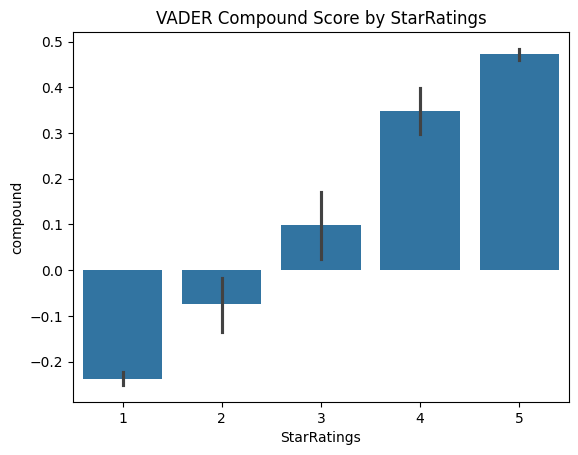

In [41]:
# Plot VADER Compound score and StarRatings
ax = sns.barplot(data=data, x='StarRatings', y='compound')
ax.set_title('VADER Compound Score by StarRatings')
plt.show()

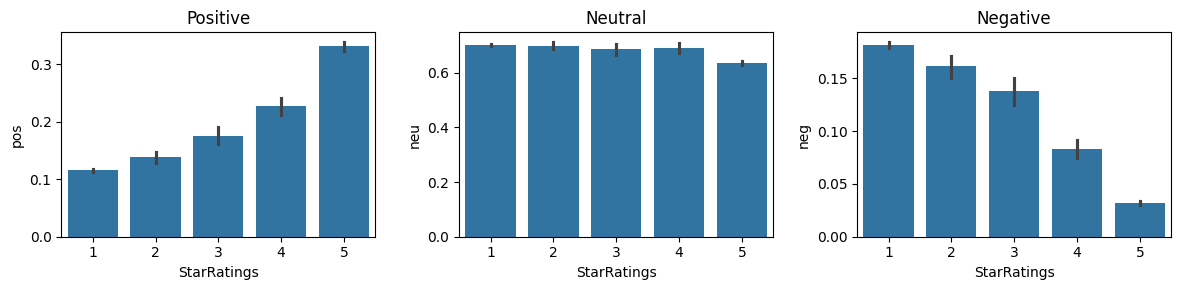

In [42]:
# Plot VADER Positive, Neutral and Negative scores and StarRatings
fig, axs = plt.subplots(1,3, figsize=(12,3))
sns.barplot(data=data, x='StarRatings', y='pos', ax=axs[0])
sns.barplot(data=data, x='StarRatings', y='neu', ax=axs[1])
sns.barplot(data=data, x='StarRatings', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [43]:
# Apply VADER sentiment analysis
data['vader_sentiment'] = data['clean_review'].apply(
    lambda x: 'positive' if sia.polarity_scores(x)['compound'] >= 0.05 else (
        'negative' if sia.polarity_scores(x)['compound'] <= -0.05 else 'neutral'))

# Filter out each sentiment from VADER sentiment analysis
positive_reviews = data[data['vader_sentiment'] == 'positive']['clean_review']
negative_reviews = data[data['vader_sentiment'] == 'negative']['clean_review']
neutral_reviews = data[data['vader_sentiment'] == 'neutral']['clean_review']

from collections import Counter

# Function to get the most common words
def get_most_common_words(reviews, n=50):
    all_words = ' '.join(reviews).split()
    return [word for word, count in Counter(all_words).most_common(n)]

# Get the top 50 most common words in positive, negative, and neutral reviews
positive_keywords = set(get_most_common_words(positive_reviews, 50))
negative_keywords = set(get_most_common_words(negative_reviews, 50))
neutral_keywords = set(get_most_common_words(neutral_reviews, 50))

print('Positive Keywords:', positive_keywords)
print('Negative Keywords:', negative_keywords)
print('Neutral Keywords:', neutral_keywords)

# Use these keywords to create the sentiment column
def determine_sentiment(text):
    text_tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    positive_count = sum(1 for word in text_tokens if word in positive_keywords)
    negative_count = sum(1 for word in text_tokens if word in negative_keywords)
    neutral_count = sum(1 for word in text_tokens if word in neutral_keywords)
    
    # Determine the sentiment based on the highest count
    if positive_count > negative_count and positive_count > neutral_count:
        return 'positive'
    elif negative_count > positive_count and negative_count > neutral_count:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the sentiment column
data['vader_review_sentiment'] = data['clean_review'].apply(determine_sentiment)

Positive Keywords: {'item', 'quality', 'product', 'back', 'company', 'shipping', 'review', 'arrived', 'never', 'money', 'sent', 'aliexpress', 'site', 'return', 'amazon', 'delivered', 'dispute', 'racking', 'day', 'well', 'store', 'dont', 'ive', 'great', 'package', 'good', 'problem', 'experience', 'fast', 'month', 'seller', 'refund', 'received', 'customer', 'get', 'buy', 'use', 'always', 'one', 'help', 'price', 'ime', 'would', 'delivery', 'ordered', 'even', 'service', 'still', 'like', 'order'}
Negative Keywords: {'got', 'item', 'said', 'product', 'back', 'company', 'shipping', 'buyer', 'never', 'money', 'wrong', 'sent', 'bought', 'aliexpress', 'site', 'return', 'delivered', 'amazon', 'dispute', 'racking', 'pay', 'day', 'store', 'dont', 'package', 'good', 'problem', 'bad', 'give', 'month', 'send', 'seller', 'scam', 'refund', 'received', 'customer', 'get', 'buy', 'didnt', 'use', 'say', 'one', 'ime', 'would', 'ordered', 'delivery', 'even', 'service', 'still', 'order'}
Neutral Keywords: {'go

In [44]:
# Apply TextBlob sentiment analysis
data['textblob_sentiment'] = data['clean_review'].apply(
    lambda x: 'positive' if TextBlob(x).sentiment.polarity > 0 else (
        'negative' if TextBlob(x).sentiment.polarity < 0 else 'neutral'))

# Filter out each sentiment from TextBlob sentiment analysis
positive_reviews = data[data['textblob_sentiment'] == 'positive']['clean_review']
negative_reviews = data[data['textblob_sentiment'] == 'negative']['clean_review']
neutral_reviews = data[data['textblob_sentiment'] == 'neutral']['clean_review']

# Function to get the most common words
def get_most_common_words(reviews, n=50):
    all_words = ' '.join(reviews).split()
    return [word for word, count in Counter(all_words).most_common(n)]

# Get the top 50 most common words in positive, negative, and neutral reviews
positive_keywords = set(get_most_common_words(positive_reviews, 50))
negative_keywords = set(get_most_common_words(negative_reviews, 50))
neutral_keywords = set(get_most_common_words(neutral_reviews, 50))

print('Positive Keywords:', positive_keywords)
print('Negative Keywords:', negative_keywords)
print('Neutral Keywords:', neutral_keywords)

# Use these keywords to create the sentiment column
def determine_sentiment(text):
    text_tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    positive_count = sum(1 for word in text_tokens if word in positive_keywords)
    negative_count = sum(1 for word in text_tokens if word in negative_keywords)
    neutral_count = sum(1 for word in text_tokens if word in neutral_keywords)
    
    # Determine the sentiment based on the highest count
    if positive_count > negative_count and positive_count > neutral_count:
        return 'positive'
    elif negative_count > positive_count and negative_count > neutral_count:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the sentiment column
data['textblob_review_sentiment'] = data['clean_review'].apply(determine_sentiment)

Positive Keywords: {'got', 'item', 'hing', 'quality', 'product', 'back', 'company', 'shipping', 'review', 'arrived', 'never', 'money', 'sent', 'bought', 'aliexpress', 'site', 'return', 'amazon', 'delivered', 'dispute', 'racking', 'day', 'store', 'dont', 'great', 'package', 'good', 'problem', 'fast', 'month', 'seller', 'year', 'refund', 'received', 'customer', 'get', 'buy', 'many', 'also', 'use', 'one', 'price', 'ime', 'would', 'delivery', 'ordered', 'even', 'service', 'like', 'order'}
Negative Keywords: {'got', 'item', 'said', 'product', 'back', 'company', 'shipping', 'arrived', 'never', 'money', 'wrong', 'sent', 'aliexpress', 'site', 'return', 'amazon', 'delivered', 'dispute', 'racking', 'day', 'contact', 'store', 'dont', 'number', 'fake', 'package', 'bad', 'give', 'month', 'send', 'seller', 'refund', 'received', 'customer', 'get', 'buy', 'didnt', 'use', 'say', 'one', 'help', 'ime', 'would', 'ordered', 'delivery', 'even', 'service', 'still', 'like', 'order'}
Neutral Keywords: {'got', 

In [45]:
# Define the sentiment function for 'StarRatings'
def star_rating_sentiment(StarRatings):
    if StarRatings == 1 or StarRatings == 2:
        return 'Negative'
    elif StarRatings == 4 or StarRatings == 5:
        return 'Positive'
    else:
        return 'Neutral'

data['StarRatings_sentiment'] = data['StarRatings'].apply(star_rating_sentiment)

In [46]:
data.head()

,ID,Reviewer,Country,StarRatings,Subject,Review,Date_posted,clean_review,neg,neu,pos,compound,vader_sentiment,vader_review_sentiment,textblob_sentiment,textblob_review_sentiment,StarRatings_sentiment
0,00,Mike Santarcangelo,US,3,"Amazon may be a fine company, but...","[amazon, easy, work, fulfill, order, via, rd, ...",2024-06-04,amazon easy work fulfill order via rd party co...,0.030,0.583,0.387,0.9432,positive,neutral,positive,negative,Neutral
1,01,Arthur Riding,GB,5,"Great range of products, generally superior qu...","[using, aliexpress, well, year, consistently, ...",2024-06-04,using aliexpress well year consistently impres...,0.000,0.694,0.306,0.9689,positive,positive,positive,positive,Positive
2,02,UK shopper Val,GB,5,Good!,"[good, customercentric, marketplace, neverthel...",2024-06-03,good customercentric marketplace nevertheless ...,0.153,0.587,0.259,0.6705,positive,positive,positive,positive,Positive
3,03,Jim Corkery,CA,1,I purchased an Android Tesla style…,"[purchased, android, tesla, style, radio, inst...",2024-06-02,purchased android esla style radio installed s...,0.000,0.909,0.091,0.5719,positive,negative,positive,neutral,Negative
4,04,chris bardin,IE,1,They are an absolute con job dont waste…,"[absolute, con, job, dont, waste, money, scamm...",2024-06-04,absolute con job dont waste money scammer rece...,0.073,0.792,0.135,0.2575,positive,neutral,neutral,neutral,Negative


In [47]:
# Evaluate TextBlob Model (Compare Textblob Sentiment with TextBlob Review Sentiment)
y_true = data['textblob_review_sentiment']
y_pred = data['textblob_sentiment']

labels = ['positive', 'neutral', 'negative']
textblob_confusion = confusion_matrix(y_true, y_pred, labels=labels)
textblob_accuracy = accuracy_score(y_true, y_pred)
textblob_f1 = f1_score(y_true, y_pred, average='weighted')
textblob_precision = precision_score(y_true, y_pred, average='weighted')
textblob_recall = recall_score(y_true, y_pred, average='weighted')

# Print the results
print('Textblob Confusion Matrix:')
print(textblob_confusion)
print('\nTextblob Accuracy Score:', textblob_accuracy)
print('Textblob F1 Score:', textblob_f1)
print('Textblob Precision Score:', textblob_precision)
print('Textblob Recall Score:', textblob_recall)

Textblob Confusion Matrix:
[[3466   90  496]
 [2603 1746 2021]
 [ 455   89 1034]]

Textblob Accuracy Score: 0.5205
Textblob F1 Score: 0.4978111913606253
Textblob Precision Score: 0.699155517611721
Textblob Recall Score: 0.5205


In [48]:
# VADER Model Evaluation (Compare VADER Sentiment with VADER Review Sentiment)
y_true = data['vader_review_sentiment']
y_pred = data['vader_sentiment']

labels = ['positive', 'neutral', 'negative']
vader_confusion = confusion_matrix(y_true, y_pred, labels=labels)
vader_accuracy = accuracy_score(y_true, y_pred)
vader_f1 = f1_score(y_true, y_pred, average='weighted')
vader_precision = precision_score(y_true, y_pred, average='weighted')
vader_recall = recall_score(y_true, y_pred, average='weighted')

# Print the results
print('Vader Confusion Matrix:')
print(vader_confusion)
print('\nVader Accuracy Score:', vader_accuracy)
print('Vader F1 Score:', vader_f1)
print('Vader Precision Score:', vader_precision)
print('Vader Recall Score:', vader_recall)

Vader Confusion Matrix:
[[1796   61  642]
 [3255 1476 2338]
 [ 658   80 1694]]

Vader Accuracy Score: 0.41383333333333333
Vader F1 Score: 0.3879664342718262
Vader Precision Score: 0.6766822905845282
Vader Recall Score: 0.41383333333333333


SENTIMENTS VISUALIZATION

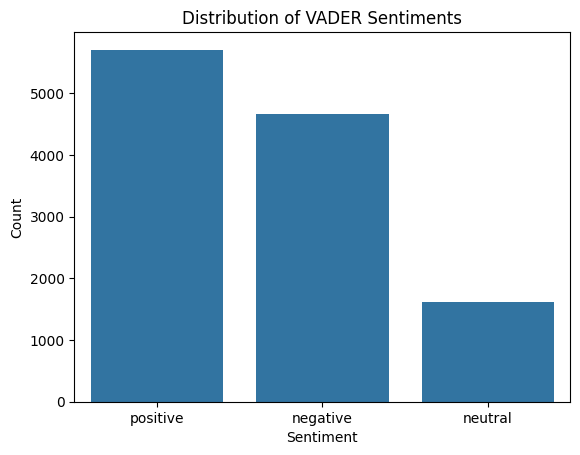

In [49]:
# Plot the distribution of sentiments
sns.countplot(x='vader_sentiment', data=data)
plt.title('Distribution of VADER Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

vader_sentiment
positive    47.58
negative    38.95
neutral     13.48
Name: count, dtype: float64


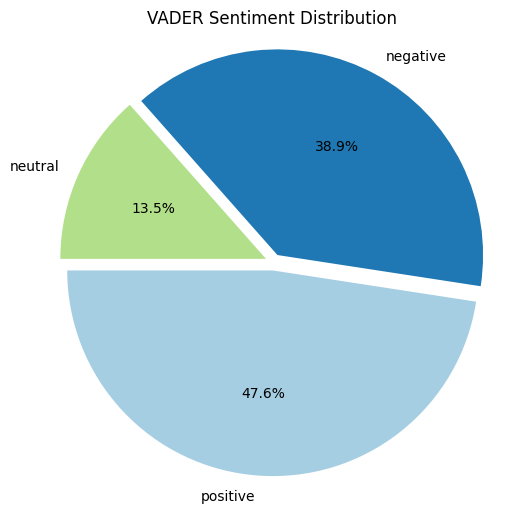

In [50]:
# Percentage Distribution of VADER Sentiment
vader_sentiment = round(data['vader_sentiment'].value_counts()/data.shape[0]*100,2)
print(vader_sentiment)

# Plot pie chart for the star ratings distribution
explode = [0.04] * len(vader_sentiment)
plt.figure(figsize=(6, 6))
plt.pie(vader_sentiment, labels=vader_sentiment.index, autopct='%1.1f%%', startangle=180, colors=plt.cm.Paired.colors, 
        explode=explode)
plt.title('VADER Sentiment Distribution')
plt.axis('equal')
plt.show()

In [51]:
# Count the occurrences of each sentiment in the 'vader_sentiment' column
vader_sentiment_counts = data['vader_sentiment'].value_counts()

# Count the occurrences of each sentiment in the 'sentiment' column
sentiment_counts = data['vader_review_sentiment'].value_counts()

# Create DataFrame for sentiment counts
sentiment_counts_data = pd.DataFrame({'VADER Sentiment': vader_sentiment_counts, 'Review Sentiment': sentiment_counts})

# Display the DataFrame
print("Sentiment Counts:")
print(sentiment_counts_data)

Sentiment Counts:
          VADER Sentiment  Review Sentiment
negative             4674              2432
neutral              1617              7069
positive             5709              2499


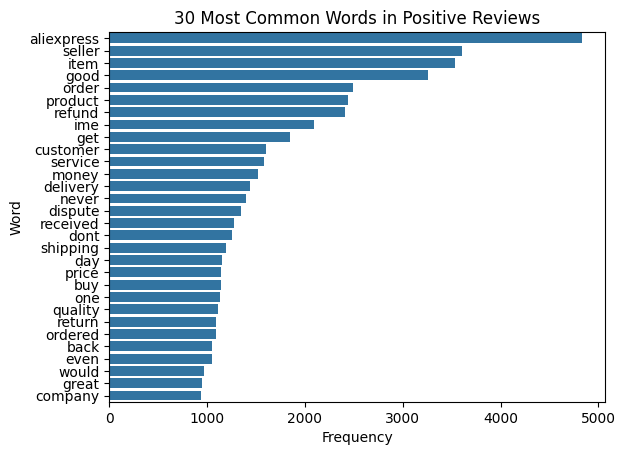

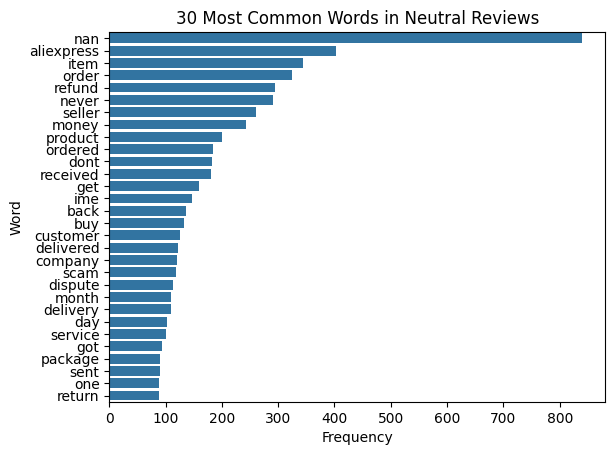

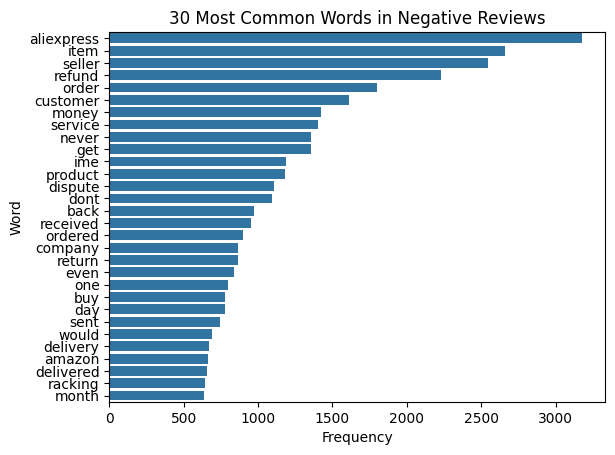

In [52]:
# Count most common words used in sentiments

# Get the most common words in positive reviews
positive_words = ' '.join(positive_reviews).split()
positive_word_freq = Counter(positive_words).most_common(30)

# Get the most common words in neutral reviews
neutral_words = ' '.join(neutral_reviews).split()
neutral_word_freq = Counter(neutral_words).most_common(30)

# Get the most common words in negative reviews
negative_words = ' '.join(negative_reviews).split()
negative_word_freq = Counter(negative_words).most_common(30)

# Plot the most common words in positive reviews
positive_df = pd.DataFrame(positive_word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=positive_df)
plt.title('30 Most Common Words in Positive Reviews')
plt.show()

# Plot the most common words in neutral reviews
neutral_df = pd.DataFrame(neutral_word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=neutral_df)
plt.title('30 Most Common Words in Neutral Reviews')
plt.show()

# Plot the most common words in negative reviews
negative_df = pd.DataFrame(negative_word_freq, columns=['Word', 'Frequency'])
sns.barplot(x='Frequency', y='Word', data=negative_df)
plt.title('30 Most Common Words in Negative Reviews')
plt.show()

vader_review_sentiment
neutral     7069
positive    2499
negative    2432
Name: count, dtype: int64


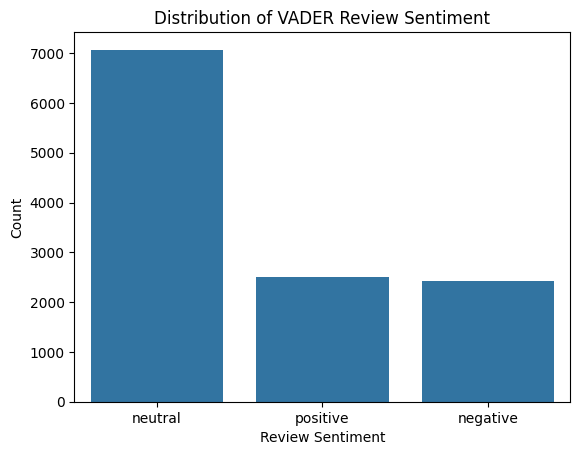

In [53]:
# Review Sentiment Distribution (VADER)
sentiment_count = data['vader_review_sentiment'].value_counts()
print(sentiment_count)

# Plot the distribution of sentiments
sns.countplot(x='vader_review_sentiment', data=data)
plt.title('Distribution of VADER Review Sentiment')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.show()

textblob_review_sentiment
neutral     6370
positive    4052
negative    1578
Name: count, dtype: int64


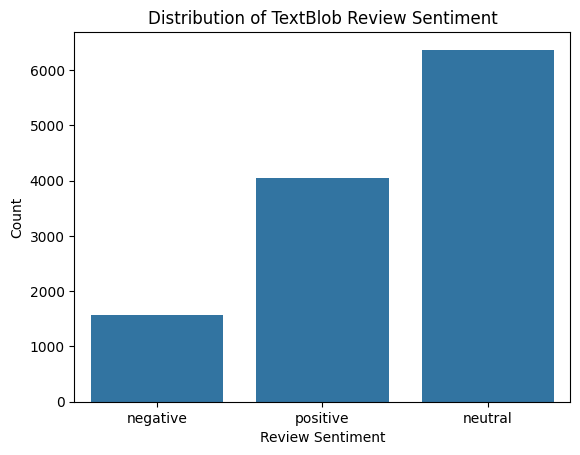

In [54]:
# Review Sentiment Distribution (TextBlob)
sentiment_count = data['textblob_review_sentiment'].value_counts()
print(sentiment_count)

# Plot the distribution of sentiments
sns.countplot(x='textblob_review_sentiment', data=data)
plt.title('Distribution of TextBlob Review Sentiment')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.show()

StarRatings_sentiment
Negative    6830
Positive    4890
Neutral      280
Name: count, dtype: int64


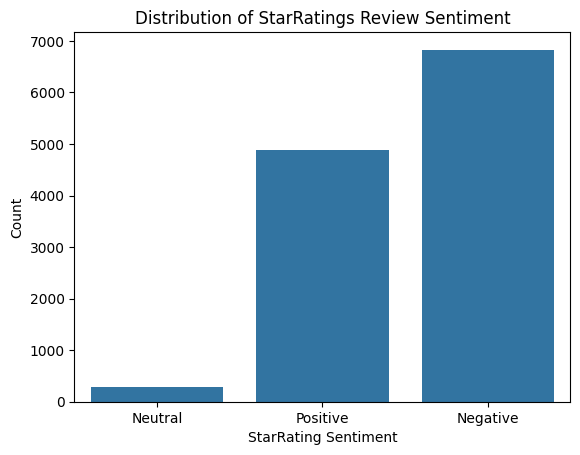

In [55]:
# Review Sentiment Distribution (StarRatings)
sentiment_count = data['StarRatings_sentiment'].value_counts()
print(sentiment_count)

# Plot the distribution of sentiments
sns.countplot(x='StarRatings_sentiment', data=data)
plt.title('Distribution of StarRatings Review Sentiment')
plt.xlabel('StarRating Sentiment')
plt.ylabel('Count')
plt.show()

vader_review_sentiment
neutral     58.91
positive    20.82
negative    20.27
Name: count, dtype: float64


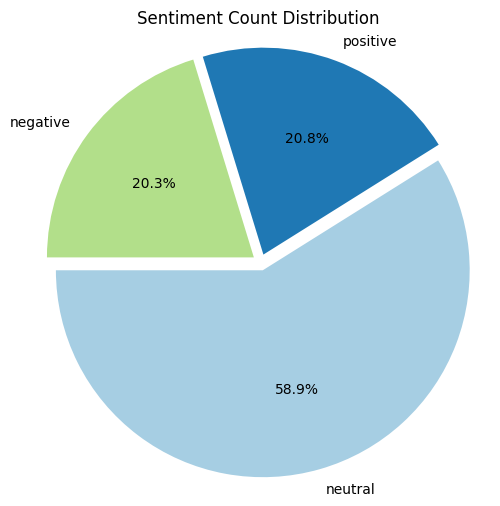

In [56]:
# Percentage Distribution of VADER review sentiment
sentiment_counts = round(data['vader_review_sentiment'].value_counts()/data.shape[0]*100,2)
print(sentiment_counts)

# Plot pie chart for the star ratings distribution
explode = [0.04] * len(sentiment_counts)
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=180, colors=plt.cm.Paired.colors, explode=explode)
plt.title('Sentiment Count Distribution')
plt.axis('equal')
plt.show()

Top 10 countries with Positive sentiment (VADER):
Country
GB    1056
US     874
CA     354
AU     281
NL     190
FR     174
BR     171
ES     156
NZ     153
IL     141
Name: count, dtype: int64


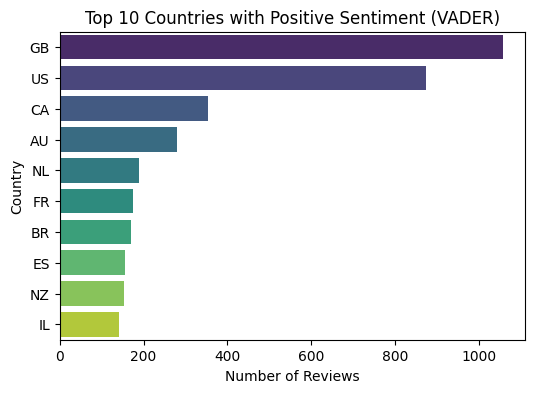

Top 10 countries with Positive sentiment (Review):
Country
GB    586
US    409
CA    162
AU    147
ES     68
NZ     68
NL     68
BR     67
DE     66
FR     65
Name: count, dtype: int64


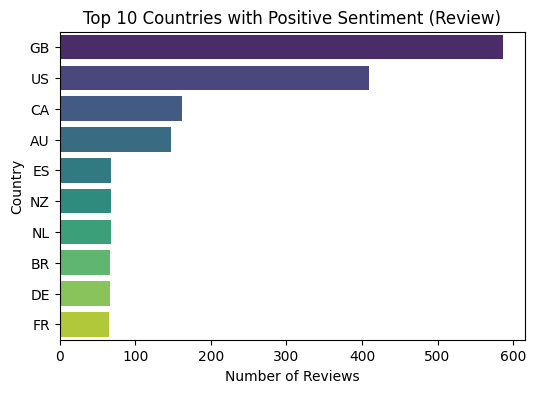

In [57]:
# Function to get top N countries by sentiment
def get_top_countries_by_sentiment(data, sentiment_column, sentiment_value, top_n=10):
    # Filter data by sentiment value
    sentiment_data = data[data[sentiment_column] == sentiment_value]
    
    # Count occurrences of each country
    country_counts = sentiment_data['Country'].value_counts().head(top_n)
    
    return country_counts

# Top 10 countries with Positive sentiment in 'vader_sentiment'

top_positive_countries_vader = get_top_countries_by_sentiment(data, 'vader_sentiment', 'positive')
print("Top 10 countries with Positive sentiment (VADER):")
print(top_positive_countries_vader)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_positive_countries_vader.values, y=top_positive_countries_vader.index, palette='viridis')
plt.title('Top 10 Countries with Positive Sentiment (VADER)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

# Top 10 countries with Positive sentiment in 'review_sentiment'

top_positive_countries_review = get_top_countries_by_sentiment(data, 'vader_review_sentiment', 'positive')
print("Top 10 countries with Positive sentiment (Review):")
print(top_positive_countries_review)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_positive_countries_review.values, y=top_positive_countries_review.index, palette='viridis')
plt.title('Top 10 Countries with Positive Sentiment (Review)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()


Top 10 countries with Neutral sentiment (VADER):
Country
US    234
GB    208
CA     77
NL     73
AU     57
ES     56
BR     55
FR     43
IT     41
NZ     38
Name: count, dtype: int64


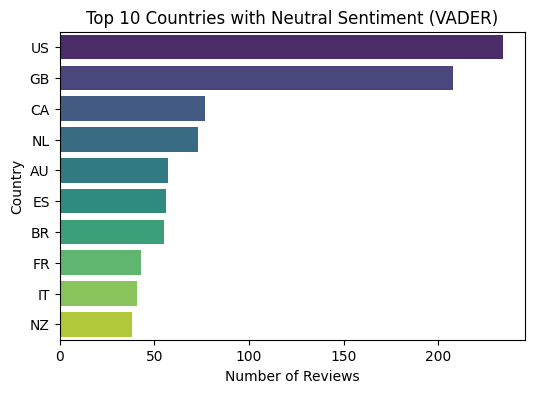


Top 10 countries with Neutral sentiment (Review):
Country
GB    1411
US    1075
CA     395
AU     320
NL     250
FR     212
ES     198
NZ     179
BR     167
IL     158
Name: count, dtype: int64


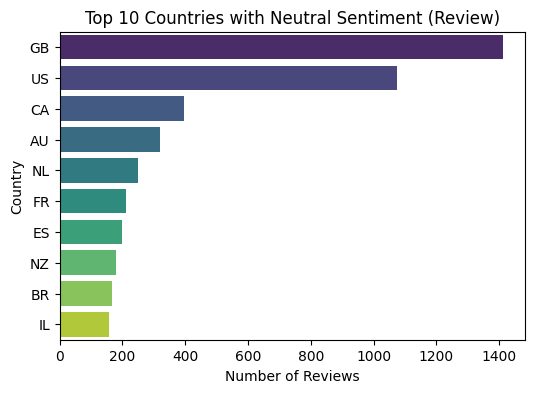

In [58]:
# Top 10 countries with Neutral sentiment in 'vader_sentiment'

top_neutral_countries_vader = get_top_countries_by_sentiment(data, 'vader_sentiment', 'neutral')
print("\nTop 10 countries with Neutral sentiment (VADER):")
print(top_neutral_countries_vader)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_neutral_countries_vader.values, y=top_neutral_countries_vader.index, palette='viridis')
plt.title('Top 10 Countries with Neutral Sentiment (VADER)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

# Top 10 countries with Neutral sentiment in 'review_sentiment'

top_neutral_countries_review = get_top_countries_by_sentiment(data, 'vader_review_sentiment', 'neutral')
print("\nTop 10 countries with Neutral sentiment (Review):")
print(top_neutral_countries_review)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_neutral_countries_review.values, y=top_neutral_countries_review.index, palette='viridis')
plt.title('Top 10 Countries with Neutral Sentiment (Review)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()


Top 10 countries with Negative sentiment (VADER):
Country
GB    1469
US     859
CA     339
AU     244
NL     123
IE     113
ES     108
DK     102
NZ      99
FR      94
Name: count, dtype: int64


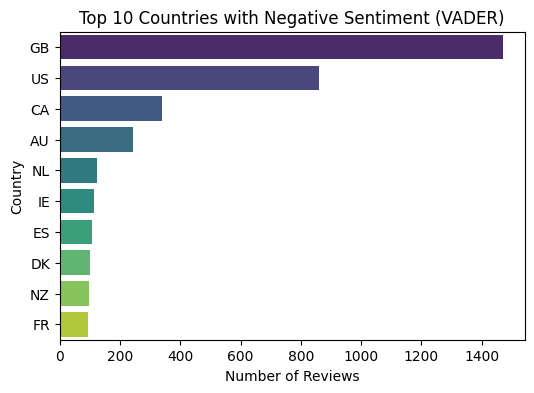


Top 10 countries with Negative sentiment (Review):
Country
GB    736
US    483
CA    213
AU    115
NL     68
IE     59
ES     54
DE     50
NZ     43
DK     43
Name: count, dtype: int64


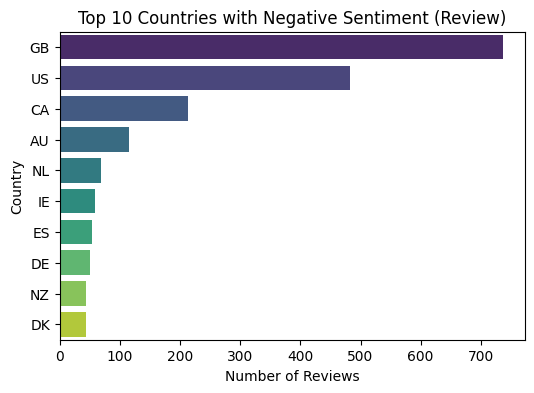

In [59]:
# Top 10 countries with Negative sentiment in 'vader_sentiment'

top_negative_countries_vader = get_top_countries_by_sentiment(data, 'vader_sentiment', 'negative')
print("\nTop 10 countries with Negative sentiment (VADER):")
print(top_negative_countries_vader)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_negative_countries_vader.values, y=top_negative_countries_vader.index, palette='viridis')
plt.title('Top 10 Countries with Negative Sentiment (VADER)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

# Top 10 countries with Negative sentiment in 'review_sentiment'

top_negative_countries_review = get_top_countries_by_sentiment(data, 'vader_review_sentiment', 'negative')
print("\nTop 10 countries with Negative sentiment (Review):")
print(top_negative_countries_review)

plt.figure(figsize=(6, 4))
sns.barplot(x=top_negative_countries_review.values, y=top_negative_countries_review.index, palette='viridis')
plt.title('Top 10 Countries with Negative Sentiment (Review)')
plt.xlabel('Number of Reviews')
plt.ylabel('Country')
plt.show()

In [60]:
# Count words frquency in the dataset
wf = data["clean_review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
wf.columns = ['words', 'wf']
wf_sorted = wf.sort_values(by='wf', ascending=False)
wf_sorted

,words,wf
39,aliexpress,8406.0
271,item,6535.0
93,seller,6413.0
174,refund,4935.0
4,order,4615.0
...,...,...
19724,thin,1.0
19743,breeze,1.0
19742,stimulating,1.0
19741,highend,1.0


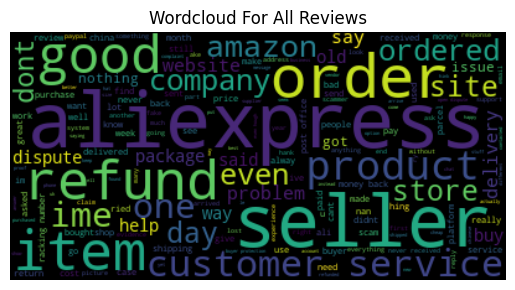

In [61]:
# Create and visualize a Word Cloud- To display the frequently occurring words in the dataset in a visual format
text = " ".join(i for i in data.clean_review)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For All Reviews')
plt.axis("off")
plt.show()

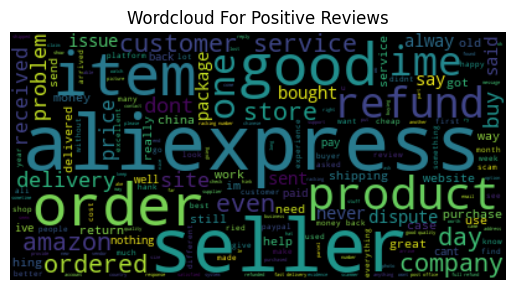

In [62]:
# Display the frequently occurring words in the positive reviews
positive_reviews_text = ' '.join(positive_reviews)

wordcloud = WordCloud().generate(positive_reviews_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For Positive Reviews')
plt.axis("off")
plt.show()

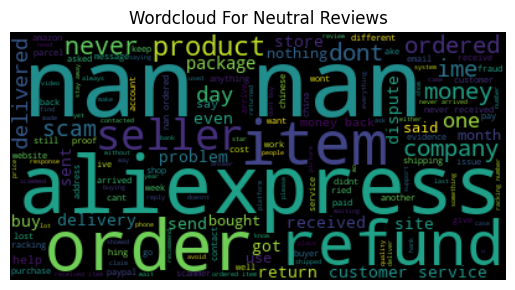

In [63]:
# Display the frequently occurring words in the negative reviews
neutral_reviews_text = ' '.join(neutral_reviews)

wordcloud = WordCloud().generate(neutral_reviews_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For Neutral Reviews')
plt.axis("off")
plt.show()

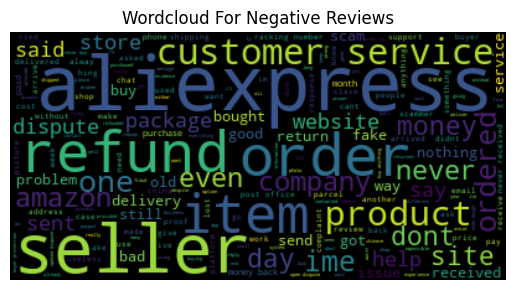

In [64]:
# Display the frequently occurring words in the negative reviews
negative_reviews_text = ' '.join(negative_reviews)

wordcloud = WordCloud().generate(negative_reviews_text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Wordcloud For Negative Reviews')
plt.axis("off")
plt.show()

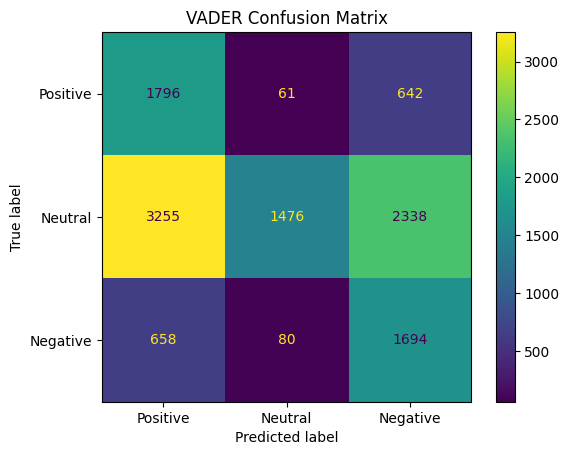

In [65]:
# Plot VADER confusion matrix
ConfusionMatrixDisplay(confusion_matrix=vader_confusion, display_labels=['Positive', 'Neutral', 'Negative']).plot()
plt.title('VADER Confusion Matrix')
plt.show()

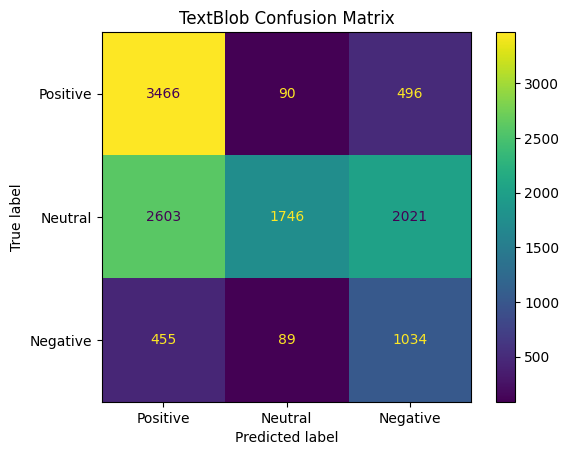

In [66]:
# Plot TextBlob confusion matrix
ConfusionMatrixDisplay(confusion_matrix=textblob_confusion, display_labels=['Positive', 'Neutral', 'Negative']).plot()
plt.title('TextBlob Confusion Matrix')
plt.show()

Correlation matrix:
                         StarRatings  vader_sentiment_numeric
StarRatings                 1.000000                 0.521968
vader_sentiment_numeric     0.521968                 1.000000


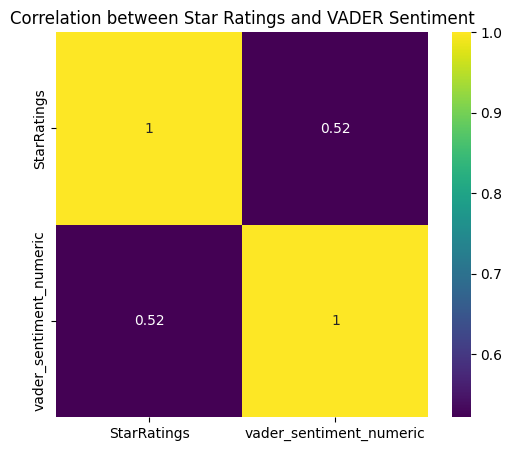

In [67]:
# Check for correlation between StarRatings and VADER Sentiment

# Convert 'vader_sentiment' to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
data['vader_sentiment_numeric'] = data['vader_sentiment'].map(sentiment_mapping)

# Check for correlation
correlation = data[['StarRatings', 'vader_sentiment_numeric']].corr()

print("Correlation matrix:")
print(correlation)

# Plotting the correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Correlation between Star Ratings and VADER Sentiment')
plt.show()

Correlation matrix:
                            StarRatings  textblob_sentiment_numeric
StarRatings                    1.000000                    0.437375
textblob_sentiment_numeric     0.437375                    1.000000


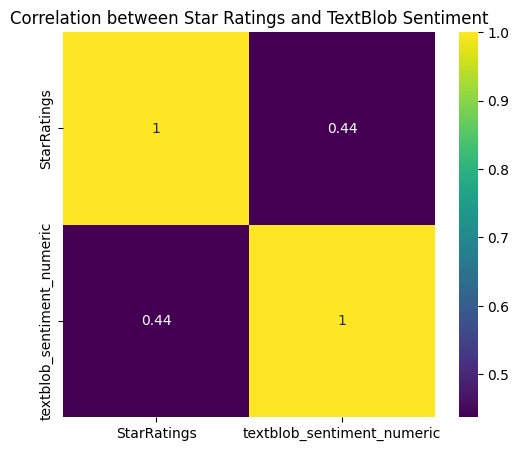

In [68]:
# Check for correlation between StarRatings and TextBlob Sentiment

# Convert 'vader_sentiment' to numerical values
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
data['textblob_sentiment_numeric'] = data['textblob_sentiment'].map(sentiment_mapping)

# Check for correlation
correlation = data[['StarRatings', 'textblob_sentiment_numeric']].corr()

print("Correlation matrix:")
print(correlation)

# Plotting the correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, annot=True, cmap='viridis')
plt.title('Correlation between Star Ratings and TextBlob Sentiment')
plt.show()

### 9. FEATURE ENGINEERING

In [69]:
# Create Bag of Words using CountVectorizer

# Instantiate CountVectorizer
cv = CountVectorizer()

# Create DTM (Document-term matrix)
dtm = cv.fit_transform(data['clean_review'])

# Convert the DTM to DataFrame
dtm_data = pd.DataFrame(dtm.toarray(), columns = cv.get_feature_names_out())

dtm_data.head()

,aa,aaa,aaaaa,aaaaaaa,aaliexpress,aalst,aan,aanbod,aangeboden,aankomst,...,zurckgesendet,zurcksenden,zwischen,zwnav,zwnavaotsr,zwo,zwok,zwykle,zysecurity,zysecury
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
#TF-IDF

#Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
x = tfidf_vectorizer.fit_transform(data['clean_review']).toarray()

# Extract target variable
y = data['vader_review_sentiment']

# Check the shape and type
print("Shape of x:", x.shape)
print("Type of x:", type(x))
print("Shape of y:", y.shape)
print("Type of y:", type(y))

# Print the first few rows of x and y
print("First few rows of x:")
print(x[:5])
print("First few rows of y:")
print(y[:5])

# Print the feature names
print("Feature names:")
print(tfidf_vectorizer.get_feature_names_out())

Shape of x: (12000, 19739)
Type of x: <class 'numpy.ndarray'>
Shape of y: (12000,)
Type of y: <class 'pandas.core.series.Series'>
First few rows of x:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First few rows of y:
0     neutral
1    positive
2    positive
3    negative
4     neutral
Name: vader_review_sentiment, dtype: object
Feature names:
['aa' 'aaa' 'aaaaa' ... 'zwykle' 'zysecurity' 'zysecury']


In [71]:
test_texts = pd.Series(['clean_review'])

### 10. MODELS DEVELOPMENT- NAIVE BAYES/LOGISTIC REGRESSION/RANDOM FOREST MODELS

In [72]:
# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(f"x train: {x_train.shape}")
print(f"x test: {x_test.shape}")
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

x train: (8400, 19739)
x test: (3600, 19739)
y train: (8400,)
y test: (3600,)


In [73]:
# Treat data imbalance
from imblearn.over_sampling import SMOTE

In [74]:
# Apply SMOTE to training features and labels sets
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [75]:
# Train Naive Bayes model

nb_model = MultinomialNB()
nb_model.fit(x_resampled, y_resampled)

MultinomialNB()

In [76]:
# Predict on the test set
nb_pred = nb_model.predict(x_test)

In [77]:
nb_pred_series = pd.Series(nb_pred)

In [78]:
neutral_texts = test_texts[nb_pred_series == 'neutral']

print(neutral_texts)

0    clean_review
dtype: object


In [79]:
# Compute metrics and confusion matrix
accuracy = accuracy_score(y_test, nb_pred)
f1 = f1_score(y_test, nb_pred, average = 'weighted', zero_division = 0)
precision = precision_score(y_test, nb_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, nb_pred, average='weighted', zero_division=0)
nb_confusion = confusion_matrix(y_test, nb_pred)

# Create DataFrame to store all metrics for the NB model
naive_baiyes_model = pd.DataFrame(nb_confusion, index=['True Negative', 'True Neutral', 'True Positive'], columns=['Pred Negative', 'Pred Neutral', 'Pred Positive'])
naive_baiyes_model.loc['Accuracy'] = ['-', '-', accuracy]
naive_baiyes_model.loc['F1 Score'] = ['-', '-', f1]
naive_baiyes_model.loc['Precision'] = ['-', '-', precision]
naive_baiyes_model.loc['Recall'] = ['-', '-', recall]

print("Naive Baye Model Results:")
print(naive_baiyes_model)

Naive Baye Model Results:
              Pred Negative Pred Neutral  Pred Positive
True Negative           670           17      38.000000
True Neutral            937          619     557.000000
True Positive           228           16     518.000000
Accuracy                  -            -       0.501944
F1 Score                  -            -       0.485166
Precision                 -            -       0.729280
Recall                    -            -       0.501944


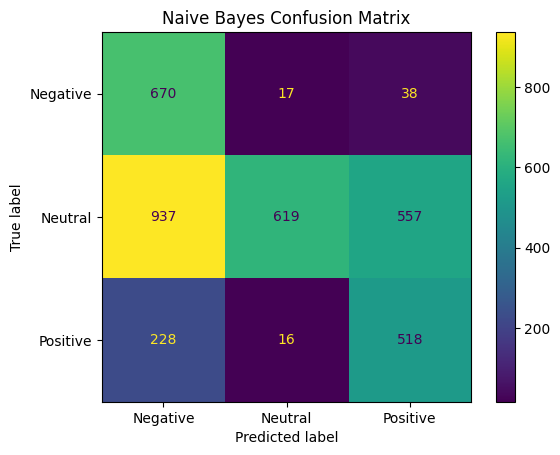

In [80]:
# Naive Bayes Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=nb_confusion, display_labels=['Negative', 'Neutral', 'Positive']).plot()
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [81]:
# Train Logistic Regression Model 

lr1_model = LogisticRegression()
lr1_model.fit(x_resampled, y_resampled)

LogisticRegression()

In [82]:
# Predict on the test set
lr1_pred = lr1_model.predict(x_test)

In [83]:
lr1_pred_series = pd.Series(lr1_pred)

In [84]:
# Compute metrics and confusion matrix
accuracy = accuracy_score(y_test, lr1_pred)
f1 = f1_score(y_test, lr1_pred, average = 'weighted', zero_division = 0)
precision = precision_score(y_test, lr1_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, lr1_pred, average='weighted', zero_division=0)
lr1_confusion = confusion_matrix(y_test, lr1_pred)

# Create DataFrame to store all metrics for the LR model
logistic_regression_model = pd.DataFrame(lr1_confusion, index=['True Negative', 'True Neutral', 'True Positive'], columns=['Pred Negative', 'Pred Neutral', 'Pred Positive'])
logistic_regression_model.loc['Accuracy'] = ['-', '-', accuracy]
logistic_regression_model.loc['F1 Score'] = ['-', '-', f1]
logistic_regression_model.loc['Precision'] = ['-', '-', precision]
logistic_regression_model.loc['Recall'] = ['-', '-', recall]

print("Logistic Regression Model Results:")
print(logistic_regression_model)

Logistic Regression Model Results:
              Pred Negative Pred Neutral  Pred Positive
True Negative           629           94       2.000000
True Neutral            153         1894      66.000000
True Positive            10          123     629.000000
Accuracy                  -            -       0.875556
F1 Score                  -            -       0.875872
Precision                 -            -       0.877567
Recall                    -            -       0.875556


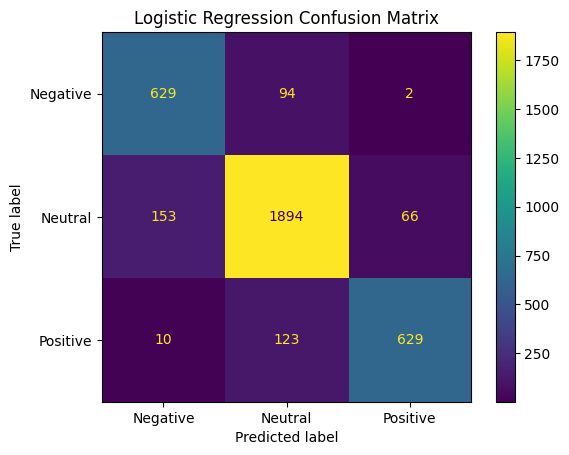

In [85]:
# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=lr1_confusion, display_labels=['Negative', 'Neutral', 'Positive']).plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

In [86]:
# Train Random Forest Model

rf_model = RandomForestClassifier()
rf_model.fit(x_resampled, y_resampled)

RandomForestClassifier()

In [87]:
# Predict on the test set
rf_pred = rf_model.predict(x_test)

In [88]:
rf_pred_series = pd.Series(rf_pred)

In [89]:
# Compute metrics and confusion matrix
accuracy = accuracy_score(y_test, rf_pred)
f1 = f1_score(y_test, rf_pred, average = 'weighted', zero_division = 0)
precision = precision_score(y_test, rf_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, rf_pred, average='weighted', zero_division=0)
rf_confusion = confusion_matrix(y_test, rf_pred)

# Create DataFrame to store all metrics for the RF model
random_forest_model = pd.DataFrame(rf_confusion, index=['True Negative', 'True Neutral', 'True Positive'], columns=['Pred Negative', 'Pred Neutral', 'Pred Positive'])
random_forest_model.loc['Accuracy'] = ['-', '-', accuracy]
random_forest_model.loc['F1 Score'] = ['-', '-', f1]
random_forest_model.loc['Precision'] = ['-', '-', precision]
random_forest_model.loc['Recall'] = ['-', '-', recall]

print("Random Forest Model Results:")
print(random_forest_model)

Random Forest Model Results:
              Pred Negative Pred Neutral  Pred Positive
True Negative           545          171       9.000000
True Neutral            255         1789      69.000000
True Positive            75          236     451.000000
Accuracy                  -            -       0.773611
F1 Score                  -            -       0.772456
Precision                 -            -       0.784055
Recall                    -            -       0.773611


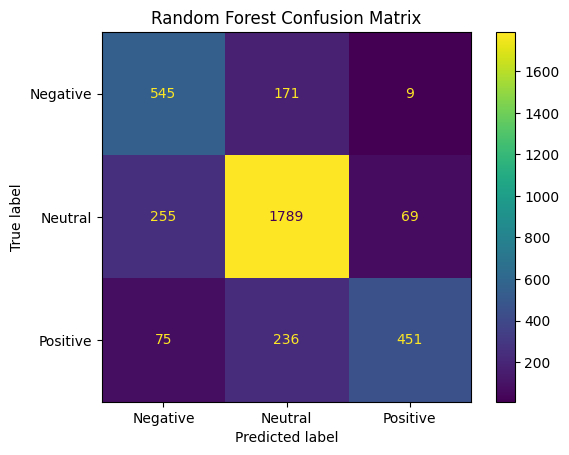

In [90]:
# Random Forest Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=rf_confusion, display_labels=['Negative', 'Neutral', 'Positive']).plot()
plt.title('Random Forest Confusion Matrix')
plt.show()

In [91]:
# Train SVC Model
svc_model = SVC()
svc_model.fit(x_resampled, y_resampled)

SVC()

In [92]:
# Predict on the test set
svc_pred = svc_model.predict(x_test)

In [93]:
svc_pred_series = pd.Series(svc_pred)

In [94]:
# Compute metrics and confusion matrix
accuracy = accuracy_score(y_test, svc_pred)
f1 = f1_score(y_test, svc_pred, average = 'weighted', zero_division = 0)
precision = precision_score(y_test, svc_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, svc_pred, average='weighted', zero_division=0)
svc_confusion = confusion_matrix(y_test, svc_pred)

# Create DataFrame to store all metrics for the SVC model
support_vector_model = pd.DataFrame(svc_confusion, index=['True Negative', 'True Neutral', 'True Positive'], columns=['Pred Negative', 'Pred Neutral', 'Pred Positive'])
support_vector_model.loc['Accuracy'] = ['-', '-', accuracy]
support_vector_model.loc['F1 Score'] = ['-', '-', f1]
support_vector_model.loc['Precision'] = ['-', '-', precision]
support_vector_model.loc['Recall'] = ['-', '-', recall]

print("Support Vector Model Results:")
print(support_vector_model)

Support Vector Model Results:
              Pred Negative Pred Neutral  Pred Positive
True Negative           504          221       0.000000
True Neutral             60         2023      30.000000
True Positive             7          265     490.000000
Accuracy                  -            -       0.838056
F1 Score                  -            -       0.832239
Precision                 -            -       0.850465
Recall                    -            -       0.838056


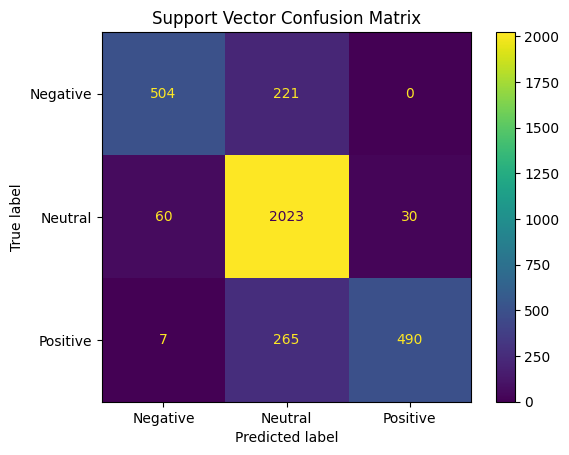

In [95]:
# SVC Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=svc_confusion, display_labels=['Negative', 'Neutral', 'Positive']).plot()
plt.title('Support Vector Confusion Matrix')
plt.show()

In [96]:
# Create DataFrame for the classification report and confusion matrix

models = ['Naive Bayes', 'Logistic Regression', 'Random Forest', 'Support Vector Machine']
predictions = [nb_pred, lr1_pred, rf_pred, svc_pred]

metrics = []
for model, preds in zip(models, predictions):
    precision = precision_score(y_test, preds, average='weighted')
    recall = recall_score(y_test, preds, average='weighted')
    f1 = f1_score(y_test, preds, average='weighted')
    accuracy = accuracy_score(y_test, preds)
    metrics.append([model, precision, recall, f1, accuracy])

# Create DataFrame
metrics_df = pd.DataFrame(metrics, columns=['Model', 'Precision_Score', 'Recall_Score', 'F1_Score', 'Accuracy'])

# Display the DataFrame
print(metrics_df)

                    Model  Precision_Score  Recall_Score  F1_Score  Accuracy
0             Naive Bayes         0.729280      0.501944  0.485166  0.501944
1     Logistic Regression         0.877567      0.875556  0.875872  0.875556
2           Random Forest         0.784055      0.773611  0.772456  0.773611
3  Support Vector Machine         0.850465      0.838056  0.832239  0.838056


Logistic Regression Model performed better than other models with high scores in all metrics

### 11. HYPERPARAMETER TUNING OF LOGISTIC REGRESSION MODEL

In [97]:
# Define the parameter grid for Random Forest
param_grid_lr1 = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}

In [98]:
# Hyperparameter tuning for Naive Bayes
random_search_lr1 = RandomizedSearchCV(estimator=lr1_model, param_distributions=param_grid_lr1, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search_lr1.fit(x_resampled, y_resampled)
best_lr1_model = random_search_lr1.best_estimator_

In [99]:
# Predict with best estimator
y_pred_best_lr1 = best_lr1_model.predict(x_test)

In [100]:
# Final evaluation on the best Random Forest model
accuracy_best_lr1 = accuracy_score(y_test, y_pred_best_lr1)
f1_best_lr1 = f1_score(y_test, y_pred_best_lr1, average='weighted')

# Compute metrics and confusion matrix
accuracy_best_lr1 = accuracy_score(y_test, y_pred_best_lr1)
f1_best_lr1 = f1_score(y_test, y_pred_best_lr1, average = 'weighted', zero_division = 0)
precision_best_lr1 = precision_score(y_test, y_pred_best_lr1, average='weighted', zero_division=0)
recall_best_lr1 = recall_score(y_test, y_pred_best_lr1, average='weighted', zero_division=0)
cm_best_lr1 = confusion_matrix(y_test, y_pred_best_lr1)

# Create DataFrame to store all metrics for the Best RF model
best_logistic_regression_model = pd.DataFrame(cm_best_lr1, index=['True Negative', 'True Neutral', 'True Positive'], columns=['Pred Negative', 'Pred Neutral', 'Pred Positive'])
best_logistic_regression_model.loc['Accuracy'] = ['-', '-', accuracy_best_lr1]
best_logistic_regression_model.loc['F1 Score'] = ['-', '-', f1_best_lr1]
best_logistic_regression_model.loc['Precision'] = ['-', '-', precision_best_lr1]
best_logistic_regression_model.loc['Recall'] = ['-', '-', recall_best_lr1]

print("Best Logistic Regression Model Results:")
print(best_logistic_regression_model)

Best Logistic Regression Model Results:
              Pred Negative Pred Neutral  Pred Positive
True Negative           598          125       2.000000
True Neutral            105         1946      62.000000
True Positive             1          146     615.000000
Accuracy                  -            -       0.877500
F1 Score                  -            -       0.876798
Precision                 -            -       0.877980
Recall                    -            -       0.877500


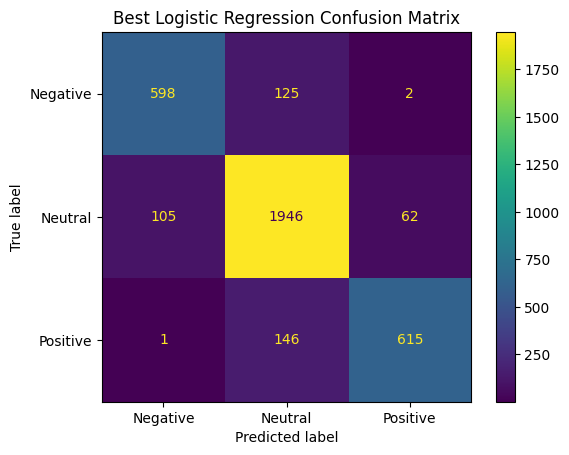

In [101]:
# Logistic Regression Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cm_best_lr1, display_labels=['Negative', 'Neutral', 'Positive']).plot()
plt.title('Best Logistic Regression Confusion Matrix')
plt.show()

### 12. SAVE MODEL AND VECTORIZER

In [102]:
pickle.dump(best_lr1_model, open('best_lr1_model.pkl', 'wb'))
pickle.dump(tfidf_vectorizer, open('tfidf_vectorizer.pkl', 'wb'))

### 13. MODEL DEPLOYMENT

In [103]:
# Define a class for the prediction
class Predictor:
    def __init__(self):
        self.model = pickle.load(open('best_lr1_model.pkl', 'rb'))
        self.vectorizer_lr1 = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))

    def predict_sentiment(self, Reviews):
        clean_review = self.clean_text(Reviews)
        print(f"Clean Review: {clean_review}")
        tfidf_vectorized_review = self.vectorizer_lr1.transform([clean_review])
        print(f"Vectorized Review: {tfidf_vectorized_review.toarray()}")
        prediction = self.model.predict(tfidf_vectorized_review)
        print(f"Prediction: {prediction}")
        return prediction[0]
    

    def clean_text(self, text):
        text = str(text)
        text = text.lower()
        text = re.sub(r"[^a-zA-Z\s]", "", text)
        text = re.sub(r"\st", " ", text).strip()
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        return " ".join(tokens)

In [104]:
# Test the Predictor class
predictor = Predictor()
print(predictor.predict_sentiment("This is a great product!"))

Clean Review: great product
Vectorized Review: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['positive']
positive


In [105]:
# Test the Predictor class
predictor = Predictor()
print(predictor.predict_sentiment("it is good but I won't use it"))

Clean Review: good wont use
Vectorized Review: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['neutral']
neutral


In [106]:
# Test the Predictor class
predictor = Predictor()
print(predictor.predict_sentiment("Bad product!"))

Clean Review: bad product
Vectorized Review: [[0. 0. 0. ... 0. 0. 0.]]
Prediction: ['negative']
negative
